In [522]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

from sklearn.ensemble import IsolationForest

In [523]:
# functions TODO: fix error probability 
def generate_dataset(normal_distribution, samples):
    
    # sample 90% from normal dataset
    gaus_dist = random.sample(list(normal_distribution), samples)
    normal_points = ["no" for e in gaus_dist]

    numbers = gaus_dist  # + error_dist 
    labels = normal_points # + outliers 

    # Create df with two columns (number, label)
    df = pd.DataFrame({'number': numbers, 'label_gt': labels})
    df["numeric_label_gt"] = np.where(df['label_gt'] == "yes", -1, 1)

    # shuffle rows
    df = df.sample(frac=1)

    return df


def train_IF(dataset, n_estimators=50, contamination=0.1,max_features=1.0):
    # Train IF
    model=IsolationForest(n_estimators=n_estimators, contamination=contamination, max_features=max_features)
    model.fit(dataset[['number']])

    dataset['scores']=model.decision_function(dataset[['number']])
    dataset['anomaly']=model.predict(dataset[['number']])
    dataset["anomaly"] = np.where(dataset['anomaly']== -1, "yes", "no")

    outliers=dataset.loc[dataset['anomaly']=="yes"]
    outlier_index=list(outliers.index)

    return model, dataset

def anomaly_detection_visualisation(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    plt.plot(df['number'],df['scores'], '.')
    plt.title("datapoints and predicted anomaly score")
    plt.xlabel("datapoint (number)")
    plt.ylabel("anomaly score")
    outliers = df[df["anomaly"] == "yes"]
    non_outliers = df[df["anomaly"] == "no"]
    
    plt.title("outliers and non outliers")
    outliers_data = pd.DataFrame({'number': outliers["number"], 'scores': outliers["scores"]})
    sns.scatterplot(x="number", y="scores", data=outliers_data, palette='red', label='outliers');

    normal_data = pd.DataFrame({'number': non_outliers["number"], 'scores': non_outliers["scores"]})
    sns.scatterplot(x="number", y= "scores", data=normal_data, palette='green', label='non outliers');


def plot_histogram_of_datasets(normal_dataset):    
    _, ax = plt.subplots(1,1,figsize=(12,8))

    sns.histplot(normal_dataset, ax=ax, shrink=0.8, stat='count').set(title=f"Non outliers: Data distribution for mean:{normal_dataset.mean()} and std:{normal_dataset.std()}")
    ax.axvline(normal_dataset.mean(), color='green', label='mean')
    ax.legend()

    plt.show()
    print(f'μ_centered ={normal_dataset.mean()}')
    print(f'σ_centered ={normal_dataset.std()}')

#plot_histogram_of_datasets(s_normal_centered,s_normal_shifted)
#anomaly_detection_visualisation(df)

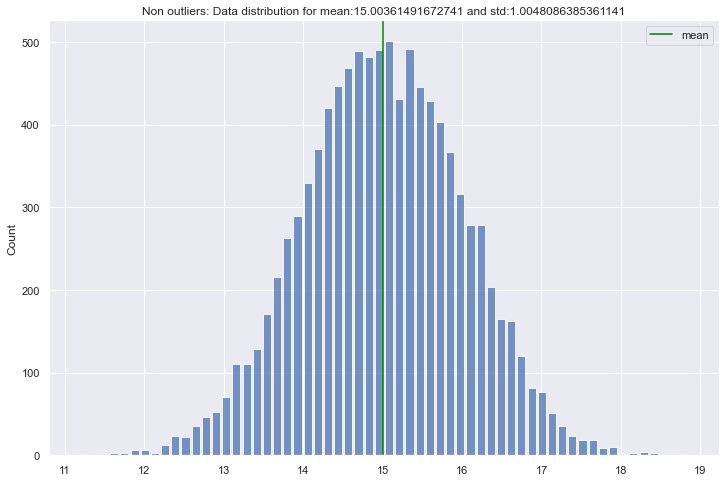

μ_centered =15.00361491672741
σ_centered =1.0048086385361141


/Users/p392827/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


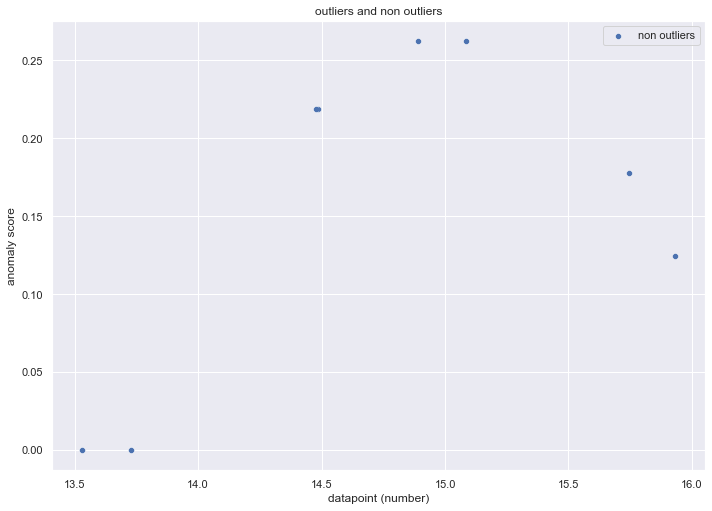

In [524]:

normal_distribution = np.random.normal(15, 1, 10000)

plot_histogram_of_datasets(normal_distribution)

# generate dataset 
ds1 = generate_dataset(normal_distribution, samples=8) # 100

# Train IF 
model, ds1_post_det = train_IF(ds1, n_estimators=2) #  n_estimators=80) # , max_features= 0.2 , contamination=n_anomaleous_samples/n_normal_samples

# Visualization
anomaly_detection_visualisation(ds1_post_det)

# Extracting / calculating hyper space parameters

In [525]:
# List of Estimators (ExtraRegressorTrees)
model.estimators_

[ExtraTreeRegressor(max_depth=3, max_features=1, random_state=129953414),
 ExtraTreeRegressor(max_depth=3, max_features=1, random_state=616004843)]

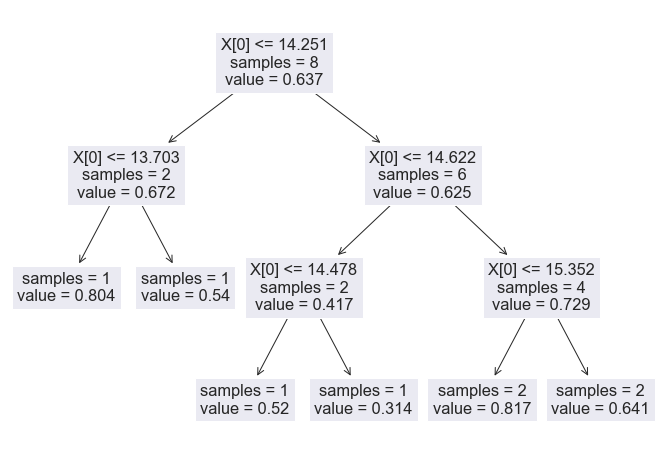

ds1['number']: 2    15.933153
6    14.486201
5    15.085304
7    15.743897
1    13.529144
4    14.477383
0    13.726483
3    14.889126
Name: number, dtype: float64
parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 1, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 129953414, 'splitter': 'random'}
number of nodes in Tree:  11
id of the left child of node i or -1 if leaf node: left children:  [ 1  2 -1 -1  5  6 -1 -1  9 -1 -1]
id of the right child of node i or -1 if leaf node: right children:  [ 4  3 -1 -1  8  7 -1 -1 10 -1 -1]
feature used for split:  [ 0  0 -2 -2  0  0 -2 -2  0 -2 -2]
thresholds [14.25079525 13.70325497 -2.         -2.         14.62205433 14.47763391
 -2.         -2.         15.35241591 -2.         -2.        ]


In [526]:

from sklearn.tree import plot_tree

# Selecting first ExtraRegressorTree
first_tree = model.estimators_[0] 

plot_tree(first_tree , impurity=False)
plt.show();

n_nodes = first_tree.tree_.node_count
children_left = first_tree.tree_.children_left
children_right = first_tree.tree_.children_right
feature = first_tree.tree_.feature
thresholds = first_tree.tree_.threshold
indices_samples_tree = model.estimators_samples_[1]
samples_tree = ds1['number'].values[indices_samples_tree]

#print("feature_names_in_:",first_tree.tree_.feature_names_in_)
print("ds1['number']:",ds1['number'])
print("parameters:",first_tree.get_params())
print("number of nodes in Tree: ",n_nodes)
print("id of the left child of node i or -1 if leaf node: left children: ",children_left)
print("id of the right child of node i or -1 if leaf node: right children: ",children_right)
print("feature used for split: ",feature)
print("thresholds",thresholds)

In [527]:
# Thresholds
print(np.unique(thresholds))
print("number of thresholds: ",len(np.unique(thresholds)))

# The subset of drawn samples for each base estimator.
print(f"Number of drawn samples to create the ExtraRegressorTree: {len(model.estimators_samples_[0])} samples_tree = { ds1['number'].values[indices_samples_tree] }")

[-2.         13.70325497 14.25079525 14.47763391 14.62205433 15.35241591]
number of thresholds:  6
Number of drawn samples to create the ExtraRegressorTree: 8 samples_tree = [15.93315316 14.48620148 15.08530397 15.74389679 13.52914436 14.47738324
 13.72648272 14.88912571]


# Iterate through decision tree (DFS)

In [528]:
def iterate_through_tree(model, tree_number):
    n_nodes = model.estimators_[tree_number].tree_.node_count
    children_left = model.estimators_[tree_number].tree_.children_left
    children_right = model.estimators_[tree_number].tree_.children_right
    features = model.estimators_[tree_number].tree_.feature
    thresholds = model.estimators_[tree_number].tree_.threshold

    # For example, the arrays feature and threshold only apply to split nodes
    # print("features:", feature)

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    # start with the root node id (0) and its depth (0)
    stack = [(0, 0)]  
    rectangle_edges = []

    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split node
        is_split_node = children_left[node_id] != children_right[node_id]

        # If a split node, append left and right children and depth to `stack` so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    return is_leaves, node_depth, children_left, children_right, features, thresholds


In [529]:
is_leaves, node_depth, children_left, children_right, features, thresholds = iterate_through_tree(model, tree_number=0)

print(f"The binary tree structure has {n_nodes} nodes and has the following tree structure:")
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node ".format(
                space=node_depth[i] * "\t",
                node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=thresholds[i],
                right=children_right[i],
            )
        )

The binary tree structure has 11 nodes and has the following tree structure:
node=0 is a split node: go to node 1 if X[:, 0] <= 14.250795249815248 else to node 4.
	node=1 is a split node: go to node 2 if X[:, 0] <= 13.70325496715809 else to node 3.
		node=2 is a leaf node 
		node=3 is a leaf node 
	node=4 is a split node: go to node 5 if X[:, 0] <= 14.622054325766326 else to node 8.
		node=5 is a split node: go to node 6 if X[:, 0] <= 14.477633912390239 else to node 7.
			node=6 is a leaf node 
			node=7 is a leaf node 
		node=8 is a split node: go to node 9 if X[:, 0] <= 15.352415912525055 else to node 10.
			node=9 is a leaf node 
			node=10 is a leaf node 


In [530]:
print("The arrays feature and threshold only apply to split nodes")
print("thresholds:",thresholds)
print("features:", feature)
print("children_left:", children_left)
print("children_right:", children_right)
print("node_depth:", node_depth)


The arrays feature and threshold only apply to split nodes
thresholds: [14.25079525 13.70325497 -2.         -2.         14.62205433 14.47763391
 -2.         -2.         15.35241591 -2.         -2.        ]
features: [ 0  0 -2 -2  0  0 -2 -2  0 -2 -2]
children_left: [ 1  2 -1 -1  5  6 -1 -1  9 -1 -1]
children_right: [ 4  3 -1 -1  8  7 -1 -1 10 -1 -1]
node_depth: [0 1 2 2 1 2 3 3 2 3 3]


children_left: [ 1  2 -1 -1  5  6 -1 -1  9 -1 -1]
children_right: [ 4  3 -1 -1  8  7 -1 -1 10 -1 -1]
These is the list of the values chosen to create the tree:  [15.93315316 14.48620148 15.08530397 15.74389679 13.52914436 14.47738324
 13.72648272 14.88912571]
This is the thresholds list: [14.25079525 13.70325497 -2.         -2.         14.62205433 14.47763391
 -2.         -2.         15.35241591 -2.         -2.        ]
split node with threshold:  14.250795249815248
split node with threshold:  13.70325496715809
split node with threshold:  14.622054325766326
split node with threshold:  14.477633912390239
split node with threshold:  15.352415912525055
sorted_thresholds: [13.70325497 14.25079525 14.47763391 14.62205433 15.35241591]
Pattern Space volume: 1
Pattern Space volume: 0.5475402826571578
Pattern Space volume: 0.2268386625749912
Pattern Space volume: 0.14442041337608735
Pattern Space volume: 0.730361586758729
Pattern Space volume: 1


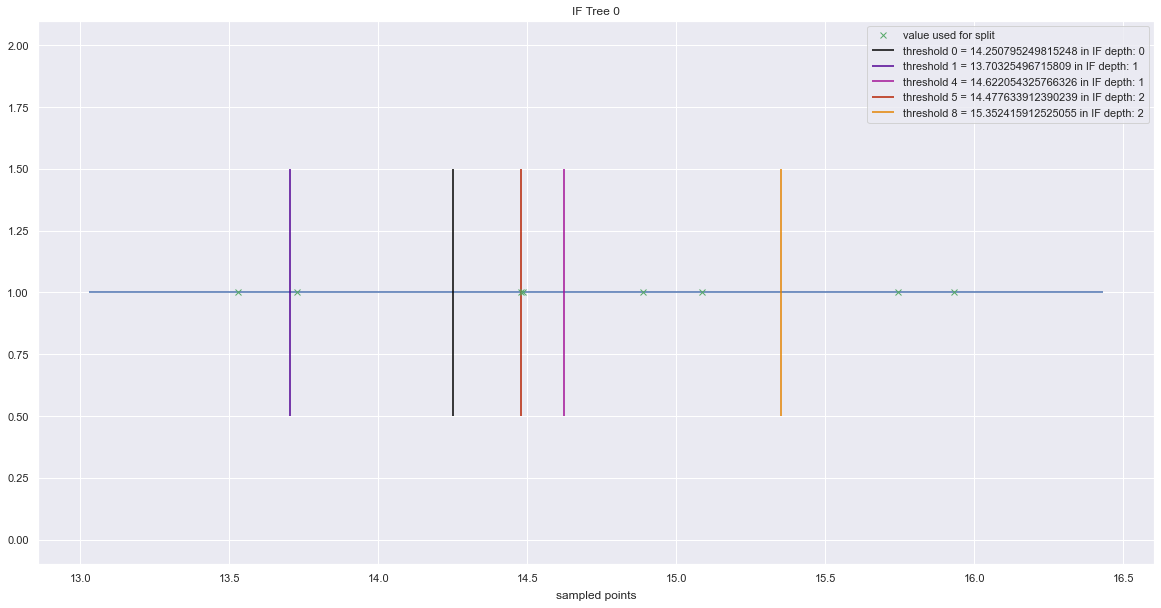

volume_pattern_space_tree:  [1, 0.5475402826571578, 0.2268386625749912, 0.14442041337608735, 0.730361586758729, 1]
children_left: [ 1  2 -1 -1  5  6 -1 -1 -1]
children_right: [ 4  3 -1 -1  8  7 -1 -1 -1]
These is the list of the values chosen to create the tree:  [15.93315316 14.48620148 15.08530397 15.74389679 13.52914436 14.47738324
 13.72648272 14.88912571]
This is the thresholds list: [14.14397623 13.63526158 -2.         -2.         15.76509952 15.47711514
 -2.         -2.         -2.        ]
split node with threshold:  14.143976233399203
split node with threshold:  13.635261582787312
split node with threshold:  15.765099517675974
split node with threshold:  15.477115136111346
sorted_thresholds: [13.63526158 14.14397623 15.47711514 15.76509952]
Pattern Space volume: 1
Pattern Space volume: 0.5087146506118909
Pattern Space volume: 1.3331389027121432
Pattern Space volume: 0.2879843815646286
Pattern Space volume: 1


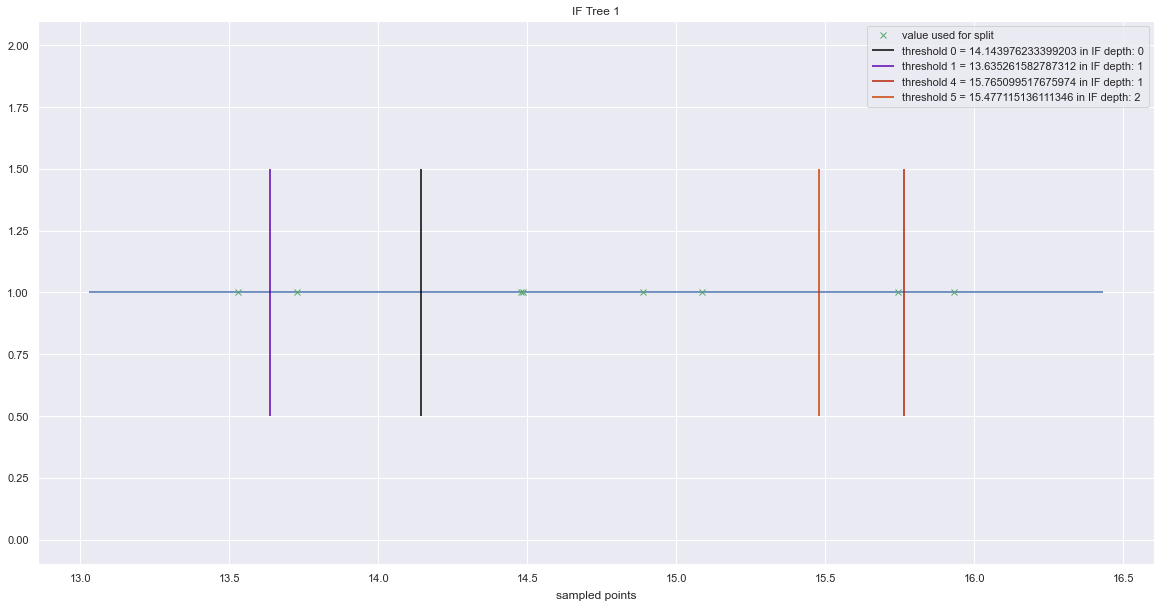

volume_pattern_space_tree:  [1, 0.5087146506118909, 1.3331389027121432, 0.2879843815646286, 1]


In [531]:
def process_hyper_planes(model, dataset):
    pattern_space_volumes = []
    cmap = plt.get_cmap('gnuplot')
    min_value = np.min(dataset['number'].values)
    max_value = np.max(dataset['number'].values)
    for p in range(len(model.estimators_samples_)):

        indices_samples_tree = model.estimators_samples_[p]
        samples_tree = dataset['number'].values[indices_samples_tree]

        is_leaves, node_depth, children_left, children_right, _, thresholds = iterate_through_tree(model, tree_number=p)

        # children_left = model.estimators_[p].tree_.children_left
        # children_right = model.estimators_[p].tree_.children_right
        print("children_left:", children_left)
        print("children_right:", children_right)
        # thresholds = model.estimators_[p].tree_.threshold
        
        print("These is the list of the values chosen to create the tree: ",samples_tree)
        print("This is the thresholds list:",thresholds)

        colors = [cmap(i) for i in np.linspace(0, 1, len((thresholds)))]
        plt.figure(figsize=(20,10))
        plt.hlines(1, min_value-0.5 ,max_value+0.5) 
        

        for i in range(0,len(thresholds),1):
            if is_leaves[i] == False:
                print("split node with threshold: ",thresholds[i])
                plt.eventplot([thresholds[i]], orientation='horizontal', colors=colors[i], label=f"threshold {i} = {thresholds[i]} in IF depth: {node_depth[i]}")

        # FIXME: only calculate Volume for leaf (pattern)
        sorted_thresholds = np.sort(np.unique(thresholds))
        filtered_sorted_thresholds = np.delete(sorted_thresholds, np.where(sorted_thresholds == -2))
        print("sorted_thresholds:",filtered_sorted_thresholds)
        
        volume_pattern_space_tree = []
        # +1 because of last half space on the 
        for c in range(len(filtered_sorted_thresholds)+1):
            if c == 0 or c == len(filtered_sorted_thresholds):
                v = 1 
            else:
                v = filtered_sorted_thresholds[c] - filtered_sorted_thresholds[c-1]
            print("Pattern Space volume:", v)
            volume_pattern_space_tree.append(v)

        samples_tree_y = [1 for s in samples_tree] 
        plt.plot(samples_tree, samples_tree_y, 'x', color='g', label="value used for split")
        plt.xlabel("sampled points", labelpad=7)
        plt.title(f"IF Tree {p}")
        plt.legend(loc='best')
        plt.show()

        print("volume_pattern_space_tree: ",volume_pattern_space_tree)
        pattern_space_volumes.append(volume_pattern_space_tree)


    return samples_tree, pattern_space_volumes, thresholds
            
sample_values_tree, pattern_space_volumes, thresholds_split_values = process_hyper_planes(model, dataset=ds1)

# Using decision path to get the list of nodes that were used to isolate the test point

In [532]:
X_test = ds1['number'].values 

node_indicator = model.estimators_[0].decision_path(np.array(X_test).reshape(-1, 1))
leaf_id = model.estimators_[0].apply(np.array(X_test).reshape(-1, 1))

sample_id = 1
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]
node_index

array([0, 4, 5, 7], dtype=int32)

In [533]:
def get_list_visited_nodes_decision_tree(model, dataset, estimator):
    X_test = dataset['number']
    decision_trees = model.estimators_
    number_of_decision_trees = len(decision_trees)
    number_of_inputs = len(dataset["number"].values)
    max_tree_depth = model.estimators_[estimator].max_depth
    visited_nodes_per_tree = np.zeros((number_of_inputs,number_of_decision_trees,max_tree_depth+1))
    for t in range(number_of_decision_trees):
        tree = decision_trees[t]
        for sample_id, n in enumerate(dataset["number"].values):
            node_indicator = tree.decision_path(np.array(X_test).reshape(-1, 1))
            # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
            node_index = node_indicator.indices[node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]
            while len(node_index) < max_tree_depth+1:
                #print("before:",node_index)
                node_index = np.append(node_index,[-1])
                #print("after",node_index)
            #print(f"Tree:{t}",node_index)
            visited_nodes_per_tree[sample_id,t] = node_index
            print(f" visited nodes for tree: {t} : {node_index}")

    return visited_nodes_per_tree

visited_nodes_per_tree = get_list_visited_nodes_decision_tree(model, ds1, estimator=0)
#print("visited_nodes_per_tree: (-1 means not defined) \n", visited_nodes_per_tree)

 visited nodes for tree: 0 : [ 0  4  8 10]
 visited nodes for tree: 0 : [0 4 5 7]
 visited nodes for tree: 0 : [0 4 8 9]
 visited nodes for tree: 0 : [ 0  4  8 10]
 visited nodes for tree: 0 : [ 0  1  2 -1]
 visited nodes for tree: 0 : [0 4 5 6]
 visited nodes for tree: 0 : [ 0  1  3 -1]
 visited nodes for tree: 0 : [0 4 8 9]
 visited nodes for tree: 1 : [ 0  4  8 -1]
 visited nodes for tree: 1 : [0 4 5 6]
 visited nodes for tree: 1 : [0 4 5 6]
 visited nodes for tree: 1 : [0 4 5 7]
 visited nodes for tree: 1 : [ 0  1  2 -1]
 visited nodes for tree: 1 : [0 4 5 6]
 visited nodes for tree: 1 : [ 0  1  3 -1]
 visited nodes for tree: 1 : [0 4 5 6]


# Evaluate data points on Pattern Space for one Tree
calculate number of points that satisfy the pattern space (located in each h space)

In [534]:
print("number of pattern spaces: ", len(pattern_space_volumes))
#print("pattern_space_volumes: ",pattern_space_volumes)
tree_number = 0
number_of_patterns_in_single_space = len(pattern_space_volumes[tree_number])
h_list = np.zeros(number_of_patterns_in_single_space)
#print("H:",H)
datapoints = ds1["number"].values
print("data points: ",datapoints)

thresholds = model.estimators_[tree_number].tree_.threshold
sorted_thresholds = np.sort(np.unique(thresholds))

# -2 is the value assigned to undefined fields in the ExtraRegressorTree (for thresholds and features)
filtered_sorted_thresholds = np.delete(sorted_thresholds, np.where(sorted_thresholds == -2)) 
print("filtered_sorted_thresholds: ",filtered_sorted_thresholds)

for c_dp , dp in enumerate(datapoints):
    for c_t , t in enumerate(filtered_sorted_thresholds):
        if dp < t:
            h_list[c_t] += 1
            print(f"dp : {dp} satisfies space {c_t}")
            break
        if dp > t and c_t == len(filtered_sorted_thresholds)-1:
            h_list[-1] += 1
            print(f"dp : {dp} satisfies space {c_t}")
            break

if np.sum(h_list) != len(datapoints):
    print("problem: not all points assigned to pattern spaces")
else:
    print("h_list one tree:",h_list)



number of pattern spaces:  2
data points:  [15.93315316 14.48620148 15.08530397 15.74389679 13.52914436 14.47738324
 13.72648272 14.88912571]
filtered_sorted_thresholds:  [13.70325497 14.25079525 14.47763391 14.62205433 15.35241591]
dp : 15.933153162945413 satisfies space 4
dp : 14.48620147714003 satisfies space 3
dp : 15.08530397197463 satisfies space 4
dp : 15.743896792340554 satisfies space 4
dp : 13.52914435961499 satisfies space 0
dp : 14.47738323920044 satisfies space 2
dp : 13.726482718837577 satisfies space 1
dp : 14.88912571196582 satisfies space 4
h_list one tree: [1. 1. 1. 1. 2. 2.]


# Calculating U_h

In [535]:
total_volume = np.sum(pattern_space_volumes[0])
print("total volume pattern space H: ",total_volume)
U_h = pattern_space_volumes[0] / total_volume
print("U_h: ",U_h)

total volume pattern space H:  3.6491609453669653
U_h:  [0.2740356  0.15004553 0.06216187 0.03957633 0.20014507 0.2740356 ]


# Assign data point to Pattern Space (one tree)

In [536]:
def find_index_pattern_space_of_data_point(data_point, filtered_sorted_thresholds, h_list):
    pattern_space = -1
    for c_t , t in enumerate(filtered_sorted_thresholds):
        if data_point < t:
            print(f"dp : {data_point} satisfies pattern space: {c_t}")
            pattern_space = c_t
            break;
        if data_point > t and c_t == len(filtered_sorted_thresholds)-1:
            print(f"dp : {data_point} satisfies last pattern space")
            pattern_space = len(filtered_sorted_thresholds)
    
    return pattern_space 

print(filtered_sorted_thresholds, h_list)

pattern_space_index = find_index_pattern_space_of_data_point(20, filtered_sorted_thresholds, h_list)
print("pattern_space_index: ",pattern_space_index)

[13.70325497 14.25079525 14.47763391 14.62205433 15.35241591] [1. 1. 1. 1. 2. 2.]
dp : 20 satisfies last pattern space
pattern_space_index:  5


# Ongoing: estimate f_hat using all the trees 

    # Done: Change plot to 1D
    # Done: draw splits in plots
    # Done: retrieve visited nodes list from Tree
    # Done: Use decision function to get list of visited nodes
    # Done: Evaluate how many data points are present per Pattern Space 
    # Done: calculate volume (length) of pattern space using leafs
    # Done: f_hat estimation using one estimator (one Tree)
    
    # Ongoing: Prepare for Wednesday: Sanity check
    # Ongoing: Check meaning of plotted values in the Tree (value?)

In [537]:
def estimate_all_pattern_spaces():
    number_of_estimators = len(model.estimators_)
    print("pattern_space_volumes: ",pattern_space_volumes)
    number_of_pattern_spaces = len(pattern_space_volumes[0])
    h_list = np.zeros(number_of_pattern_spaces)
    #print("H:",H)
    datapoints = ds1["number"].values
    print("data points: ",datapoints)

    thresholds = model.estimators_[0].tree_.threshold
    sorted_thresholds = np.sort(np.unique(thresholds))

    # -2 is the value assigned to undefined fields in the ExtraRegressorTree (for thresholds and features)
    filtered_sorted_thresholds = np.delete(sorted_thresholds, np.where(sorted_thresholds == -2)) 
    print("filtered_sorted_thresholds: ",filtered_sorted_thresholds)

    for c_dp , dp in enumerate(datapoints):
        for c_t , t in enumerate(filtered_sorted_thresholds):
            if dp < t:
                h_list[c_t] += 1
                print(f"dp : {dp} satisfies space {c_t}")
                break
            if dp > t and c_t == len(filtered_sorted_thresholds)-1:
                h_list[-1] += 1
                print(f"dp : {dp} satisfies space {c_t}")
                break


    if np.sum(h_list) != len(datapoints):
        print("problem: not all points assigned to pattern spaces")
    else:
        print("h_list one tree:",h_list)



In [550]:
def f_hat(data_point, H, data_set, U_h, filtered_sorted_thresholds):
	'''
	x : datapoint
	H : set of pattern spaces 
    |D| : size of training set?
	U_h : The area of the rectangle (pattern) in the pattern space divided by the area of the biggest rectangle
	filtered_sorted_thresholds : Thresholds for split nodes in ExtraRegressorTree
	'''
	pattern_space_index = find_index_pattern_space_of_data_point(data_point, filtered_sorted_thresholds, H)

	f_hat = (H[pattern_space_index]) / (len(data_set) * U_h[pattern_space_index])
	return f_hat


print("thresholds: ", filtered_sorted_thresholds)

# for elem in range(0,500,1):
estimate = f_hat(elem, h_list, ds1["number"].values, U_h, filtered_sorted_thresholds)
print("f_hat:", estimate)

thresholds:  [13.70325497 14.25079525 14.47763391 14.62205433 15.35241591]
dp : 499 satisfies last pattern space
f_hat: 0.9122902363417413


# Algorithm PAC_RPAD

# generator instead of for loops 
# switch to pthon files instead of notebook (class)
# conv hall 
# fix h_list

In [539]:
# TODO: How to calculate log(H) 
# TODO: Add time complexity to the calculation of the size of the training dataset (O-Notation)

def rare_pattern_detect(training_dataset, delta, tau, epsilon):
	'''
	delta : failure probability
	tau : detection threshold
	epsilon : tolerance parameter
	'''

	H_hat = estimate_pattern_space(training_dataset)

	# Define Threshold for the estimated pattern probability
	mu = tau + epsilon / 2

	# Not needed cause we already have the dataset: 
	# - calculate the number of samples to draw using sample complexity
	# - N = size_training_dataset_D(delta, epsilon, H) # (1/epsilon**2) * (np.log(H) + np.log(1/delta))
	# - draw training set D of N instances from P
	# - D = generate_training_dataset(N, P)

	results = []
	# for each data point x in training_dataset do:
	for datapoint_counter, x in enumerate(D):
		classification_decision = has_rare_pattern(x,training_dataset,H_hat,mu)
		results.append([x,classification_decision])

	return results


def estimate_pattern_space(training_dataset): # -> list_of_patterns:
	# call IF (training_dataset)
	# TODO: extract the patterns from the estimators (ExtraTreeRegressor list)
    # H = pattern space (list of ExtraTreeRegressor)
    H = model.estimators_

	return H_hat


def has_rare_pattern(x,D,H_hat,mu):
	'''
	x : datapoint
	D : trained set 
	H : pattern space 
	mu : Threshold for the estimated frequency of a pattern to be detected :  tau + epsilon/2
	'''
	U_h = calculate_U_h(x, H)

	# size_D = calculate_size_of_training_data_set(D) # |D| # (length of D)
	for pattern_counter, h in enumerate(H): 

		# estimate the normalized pattern probiblites (f_hat) using the patterns h that that satistfy h(x) == 1  
		estimated_pattern_probability = f_hat(x, h, D, U_h)

		# decision_rule: detect x as anomaleous if any estimated normalized pattern probability is smaller than mu (f_hat(h) < mu)
		if estimated_pattern_probability < mu:
			rare = True # (anomaly)
		else:
			rare = False # (normal)

		decision.append(estimated_pattern_probability, rare)

	return rare


def f_hat(x, h, D, U_h):
	'''
	x : datapoint
	h : trained set 
	|D| : size of training set?
	U_h : The area of the rectangle (pattern) in the pattern space
	'''
	# list of points that satisfy h(x) == 1
	l = [x if h(x) == 1 for x in D]
	f_hat = (len(l)) / (len(D) * U_h)
	return f_hat


def calculate_U_h(x, H):
	"""
	Calculate U(h) based on the area of the hyper rectangle used to isolate the data point
	x : data point
	H : Pattern space
	"""
	return U_h

TabError: inconsistent use of tabs and spaces in indentation (4153942981.py, line 37)